#LSTM

LSTM is a variant of RNN used in deep learning. You can use LSTMs if you are working on sequences of data.

Here are the most straightforward use-cases for LSTM networks you might be familiar with:

* Time series forecasting (for example, stock prediction)
* Text generation
* Video classification
* Music generation
* Anomaly detection

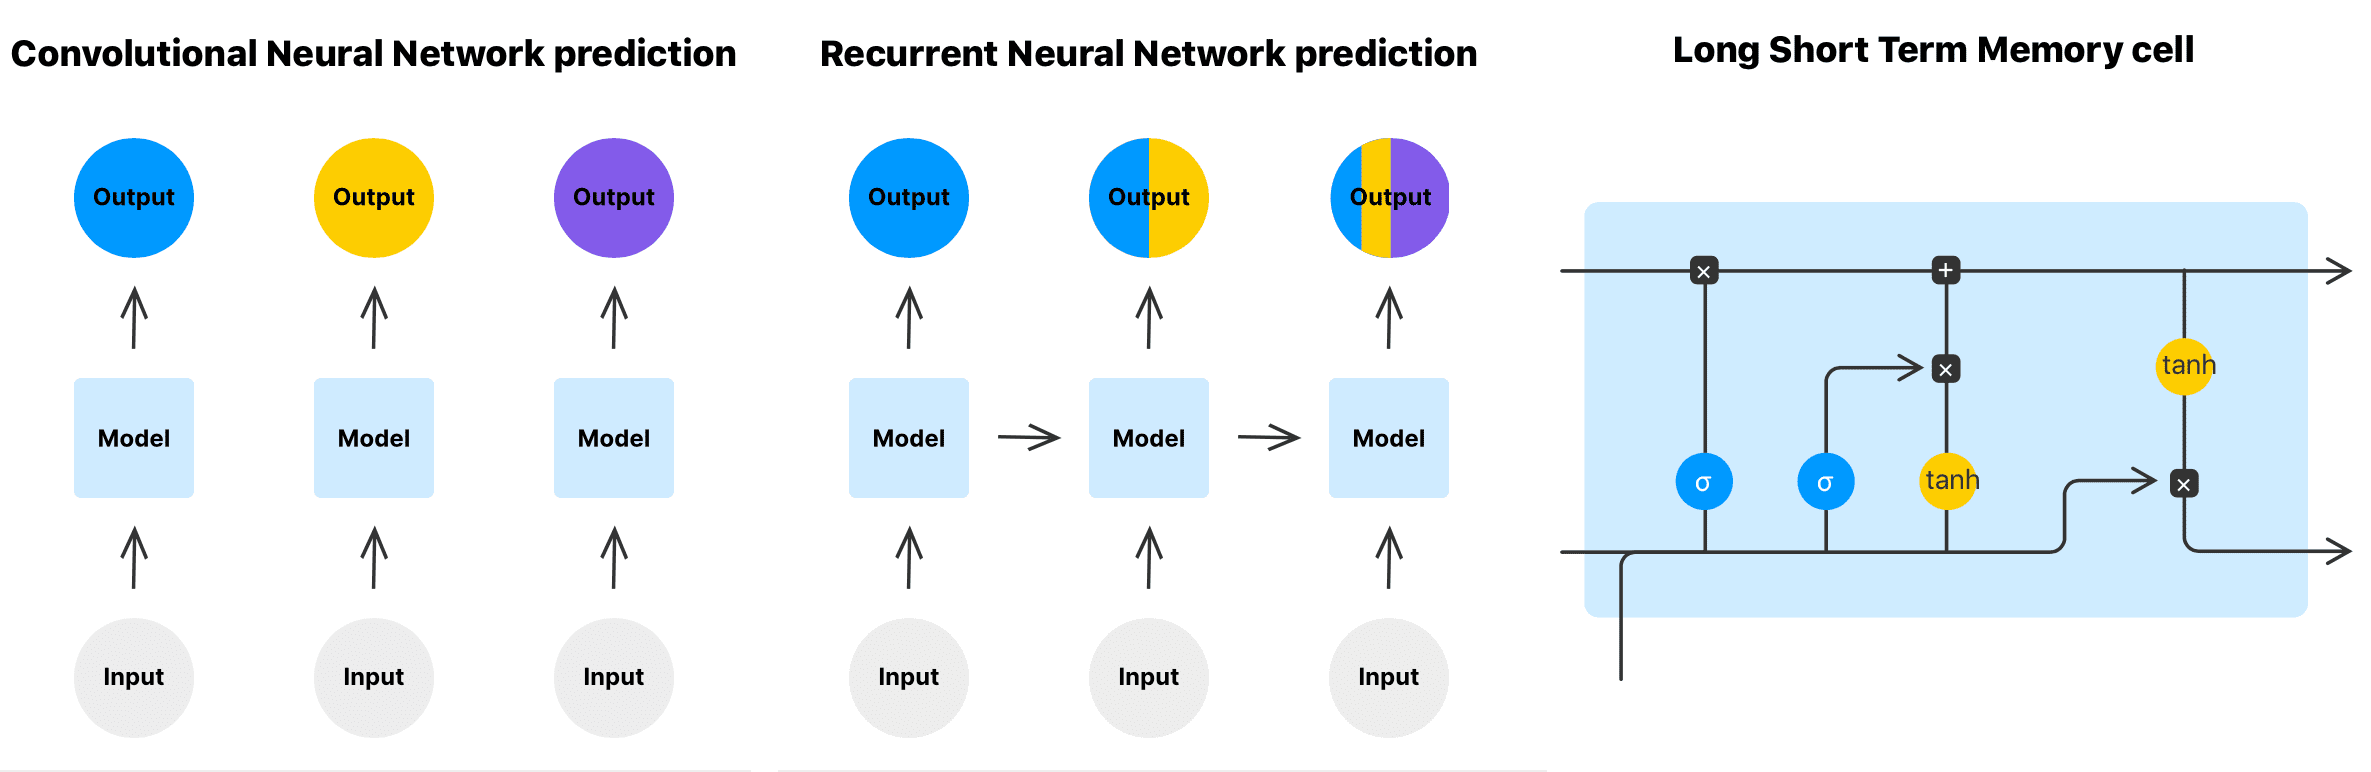

In [ ]:
!wget https://raw.githubusercontent.com/amoudgl/short-jokes-dataset/master/data/reddit-cleanjokes.csv

--2024-04-13 15:57:04--  https://raw.githubusercontent.com/amoudgl/short-jokes-dataset/master/data/reddit-cleanjokes.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 141847 (139K) [text/plain]
Saving to: ‘reddit-cleanjokes.csv’

reddit-cleanjokes.c 100%[===================>] 138.52K  --.-KB/s    in 0.02s   

2024-04-13 15:57:04 (6.10 MB/s) - ‘reddit-cleanjokes.csv’ saved [141847/141847]



In [ ]:
import torch
import numpy as np
from torch import nn, optim
from torch.utils.data import DataLoader, Dataset
from torch.nn.utils import clip_grad_norm_
import pandas as pd
from collections import Counter

In [ ]:
from torch.nn import init
class Model(nn.Module):
      def __init__(self, dataset):
        super(Model, self).__init__()
        self.lstm_size = 128
        self.embedding_dim = 128
        self.num_layers = 3

        n_vocab = len(dataset.uniq_words)
        self.embedding = nn.Embedding(
            num_embeddings=n_vocab,
            embedding_dim=self.embedding_dim,
        )

        dropout_value = 0.2 if self.num_layers > 1 else 0
        self.lstm = nn.LSTM(
            input_size=self.lstm_size,
            hidden_size=self.lstm_size,
            num_layers=self.num_layers,
            dropout=dropout_value,
        )

        self.fc = nn.Linear(self.lstm_size, n_vocab)

        self.init_weights()

      def init_weights(self):
          # Initialize embedding and linear layers
          init.xavier_uniform_(self.embedding.weight)
          init.kaiming_uniform_(self.fc.weight, nonlinearity='relu')

          # Initialize LSTM weights
          for name, param in self.lstm.named_parameters():
              if 'weight_ih' in name:
                  init.xavier_uniform_(param.data)
              elif 'weight_hh' in name:
                  init.orthogonal_(param.data)
              elif 'bias' in name:
                  param.data.fill_(0)


      def forward(self, x, prev_state):
        embed = self.embedding(x)
        output, state = self.lstm(embed, prev_state)
        logits = self.fc(output)
        return logits, state

      # Initialize weights


      def init_state(self, sequence_length):
        return (torch.zeros(self.num_layers, sequence_length, self.lstm_size),
                torch.zeros(self.num_layers, sequence_length, self.lstm_size))

In [ ]:
class Dataset(Dataset):
    def __init__(
        self,
        args,
    ):
        self.args = args
        self.words = self.load_words()
        self.uniq_words = self.get_uniq_words()

        self.index_to_word = {index: word for index, word in enumerate(self.uniq_words)}
        self.word_to_index = {word: index for index, word in enumerate(self.uniq_words)}

        self.words_indexes = [self.word_to_index[w] for w in self.words]

    def load_words(self):
        train_df = pd.read_csv('reddit-cleanjokes.csv')
        jokes = train_df['Joke'].tolist()
        text = ' <eos> '.join(jokes)
        return text.split(' ')

    def get_uniq_words(self):
        word_counts = Counter(self.words)
        return sorted(word_counts, key=word_counts.get, reverse=True)

    def __len__(self):
        return len(self.words_indexes) - self.args.sequence_length

    def __getitem__(self, index):
        return (
            torch.tensor(self.words_indexes[index:index+self.args.sequence_length], dtype=torch.int64),
            torch.tensor(self.words_indexes[index+1:index+self.args.sequence_length+1], dtype=torch.int64),
        )


In [ ]:
def train(dataset, model, args):
    model.train()
    dataloader = DataLoader(dataset, batch_size=args.batch_size)
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=0.001)

    for epoch in range(args.max_epochs):
        state_h, state_c = model.init_state(args.sequence_length)

        for batch, (x, y) in enumerate(dataloader):
            optimizer.zero_grad()

            y_pred, (state_h, state_c) = model(x, (state_h, state_c))
            loss = criterion(y_pred.transpose(1, 2), y)

            state_h = state_h.detach()
            state_c = state_c.detach()


            loss.backward()
            clip_grad_norm_(model.parameters(), max_norm=1)
            optimizer.step()

            if batch % 100 == 0:  # Adjust the frequency of logging as needed
                print({'epoch': epoch, 'batch': batch, 'loss': loss.item()})
        if epoch % 10 == 0:  # Save the model every 10 epochs
            torch.save(model.state_dict(), f'/content/model_epoch_{epoch}.pth')

In [ ]:
def predict(dataset, model, text, next_words=100, temperature=1.0):
    model.eval()

    words = text.split(' ')
    state_h, state_c = model.init_state(len(words))

    for i in range(0, next_words):
        x = torch.tensor([[dataset.word_to_index[w] for w in words[i:]]])
        #x = x.to(model.device)
        y_pred, (state_h, state_c) = model(x, (state_h, state_c))

        last_word_logits = y_pred[0][-1]
        p = nn.functional.softmax(last_word_logits / temperature, dim=0).detach().numpy()
        word_index = np.random.choice(len(last_word_logits), p=p)
        words.append(dataset.index_to_word[word_index])

    return words

In [ ]:
class Args:
    max_epochs = 10
    batch_size = 256
    sequence_length = 4
args = Args()

In [ ]:
dataset = Dataset(args)
model = Model(dataset)

train(dataset, model, args)

{'epoch': 0, 'batch': 0, 'loss': 8.842535018920898}
{'epoch': 1, 'batch': 0, 'loss': 6.936790943145752}
{'epoch': 2, 'batch': 0, 'loss': 6.872300148010254}
{'epoch': 3, 'batch': 0, 'loss': 6.7191901206970215}
{'epoch': 4, 'batch': 0, 'loss': 6.5296549797058105}
{'epoch': 5, 'batch': 0, 'loss': 6.3393778800964355}
{'epoch': 6, 'batch': 0, 'loss': 6.1748366355896}
{'epoch': 7, 'batch': 0, 'loss': 6.000690460205078}
{'epoch': 8, 'batch': 0, 'loss': 5.861403465270996}
{'epoch': 9, 'batch': 0, 'loss': 5.705016136169434}


In [ ]:
prompt = "Why did the chicken cross the road?"
generated_words = predict(dataset, model, text=prompt, next_words=50)

# Combine the prompt and the generated words
full_text = prompt + ' ' + ' '.join(generated_words[len(prompt.split()):])

# Post-process for capitalization and proper spacing after punctuation
processed_text = ' '.join([word.capitalize() if i == 0 or full_text[i - 2] in '.!?' else word
                           for i, word in enumerate(full_text.split())])

print(processed_text)

Why did the chicken cross the road? list. Mom said and the beneath Super shops? !!!! three rockstar <eos> What do you hear the with up a aboard. we beat order a levels. eight? collects Tywalkasoreus <eos> Have did the man say To to the socks, for it exist. the coat... <eos> Apparently ate get hear me
